In **LangChain**, **parallelization** :
refers to the process of executing multiple tasks concurrently rather than sequentially, which can significantly speed up workflows that involve multiple calls to language models, APIs, or chains. This is particularly useful when you have independent operations that don’t need to wait for each other.

Here’s a detailed breakdown:

---

### **1. Why Parallelization Matters in LangChain**

* LangChain workflows often involve **chains** or **agents** that call LLMs, tools, or APIs.
* By default, these calls happen **sequentially**, which can be slow if you’re making multiple requests.
* Parallelization allows you to **execute multiple calls simultaneously**, reducing latency.

---

### **2. How Parallelization Works**

LangChain provides **tools** to parallelize tasks:

#### **a) `map` and `map_reduce` in LLMChain**

* Suppose you have a list of prompts that you want to process using the same LLM.
* Instead of processing them one by one:

```python
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI

llm = OpenAI()
template = "Summarize the following text: {text}"
prompt = PromptTemplate(template=template, input_variables=["text"])
chain = LLMChain(llm=llm, prompt=prompt)

texts = ["Text 1...", "Text 2...", "Text 3..."]

# Sequential processing (slower)
results = [chain.run({"text": t}) for t in texts]

# Parallel processing (faster)
results_parallel = chain.parallel_run([{"text": t} for t in texts])
```

Here, `parallel_run` executes LLM calls concurrently.

---

#### **b) `ThreadPoolExecutor` / `ProcessPoolExecutor`**

* LangChain chains and agents can also be run in **custom parallel pipelines** using Python’s `concurrent.futures`.
* Useful when you need fine-grained control over parallelism.

---

#### **c) Agent Parallelization**

* If an agent needs to call **multiple tools independently**, you can run those calls in parallel using async functions:

```python
import asyncio

async def run_agents_in_parallel(agent_inputs):
    tasks = [agent.arun(input_text) for input_text in agent_inputs]
    return await asyncio.gather(*tasks)

results = asyncio.run(run_agents_in_parallel(["Query 1", "Query 2", "Query 3"]))
```

---

### **3. Benefits**

* **Speed**: Executes multiple LLM/API calls concurrently.
* **Efficiency**: Reduces idle time between sequential requests.
* **Scalability**: Handles batch processing more effectively.

---

### **4. Important Considerations**

* **Rate limits**: LLM APIs like OpenAI may have request limits, so parallelization could hit those limits.
* **Resource usage**: More parallel tasks mean more CPU/memory or more concurrent API calls.
* **Error handling**: Need to handle failures in individual tasks gracefully.

---

**Summary:**

In LangChain, **parallelization** is about running multiple chains, prompts, or agent actions at the same time instead of one after another. You can achieve it using `parallel_run`, async functions, or Python concurrency tools, which speeds up workflows and improves efficiency.

---

If you want, I can make a **small diagram showing sequential vs parallel execution in LangChain**—it really makes the concept click. Do you want me to do that?


In [36]:
import os 
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model = "qwen/qwen3-32b")
result = llm.invoke("Hello")
result


AIMessage(content='<think>\nOkay, the user said "Hello". I need to respond appropriately. Since this is the first message, I should greet them back and offer assistance. Let me check the guidelines to make sure I\'m following the right tone. Keep it friendly and open-ended. Maybe ask how I can help them today. That should cover it.\n</think>\n\nHi there! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 9, 'total_tokens': 92, 'completion_time': 0.165870009, 'prompt_time': 0.000393474, 'queue_time': 0.067229116, 'total_time': 0.166263483}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--8985ecb2-f78c-4e85-99d7-9d60d0aebd0f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 83, 'total_tokens': 92})

In [37]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph , START , END
from IPython.display import Image , display

# Graph Story

class State(TypedDict):
    topic:str
    character:str
    setting:str
    premises:str
    story_intro:str

In [38]:
def generate_character(state:State):
    """Generate character descriptions"""
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {"character":msg.content}


def generate_setting(state:State):
    """Generate a story setting"""
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return  {"setting":msg.content}


def generate_premise(state:State):
    """Generate a story premises"""
    msg = llm.invoke(f"Write a one-sentence plot premise for a story about  {state['topic']}")
    return {"premises":msg.content}


def combine_elements(state:State):
    """combined characters, setting and premise into intro"""  
    msg = llm.invoke(
        f"write a short story introduction using there elements:\n"
        f"Character: {state['setting']}\n"
        f"Setting: {state['premises']}"
    )
    return {"story_intro":msg.content}


In [39]:
## Build a graph

graph = StateGraph(State)
graph.add_node("character",generate_character)
graph.add_node("setting",generate_setting)
graph.add_node("premise",generate_premise)
graph.add_node("combine",combine_elements)

In [40]:
graph.add_edge(START,"character")
graph.add_edge(START,"setting")
graph.add_edge(START,"premise")
graph.add_edge("character","combine")
graph.add_edge("setting","combine")
graph.add_edge("premise","combine")
graph.add_edge("combine",END)

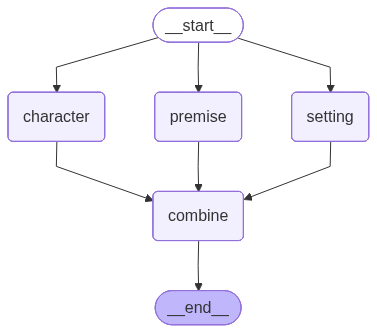

In [41]:
# Compile the graph

compiled_graph = graph.compile()

# Visualis the graph 

graph_image  = compiled_graph.get_graph().draw_mermaid_png()

display(Image(graph_image))

In [42]:
## Run the Graph

state = {"topic":"World with Crypto"}
result = compiled_graph.invoke(state)
result

{'topic': 'World with Crypto',
 'character': '<think>\nOkay, the user wants me to create two character names and brief traits for a story set in a "World with Crypto." Let me start by understanding the setting. A world centered around cryptocurrency—maybe it\'s a futuristic or alternate reality where crypto is the main form of currency, or perhaps it\'s a more dystopian or utopian society shaped by blockchain technology.\n\nFirst, I need to come up with names that reflect the crypto theme. Maybe something techy or with a modern twist. Let me think... For the first character, maybe a hacker or someone involved in the technical side. A name like "Zara" sounds modern and could work. Maybe she\'s a blockchain developer or something. For traits, maybe she\'s a prodigy, involved in decentralized networks, and has a rebellious streak against centralized systems.\n\nWait, the user mentioned "brief traits," so I need to keep it concise. Let me outline: Name, Role, Key Traits. So Zara could be a

In [43]:
print(result["story_intro"])

<think>
Okay, let's see. The user wants a short story introduction using the provided elements. They already have a detailed setting for a crypto-based world called Crypto Haven. The next step is to create a compelling opening that hooks the reader. The story should introduce the setting and the conflict. The user mentioned elements like the Quantum Exchange, the Global Ledger, and the protagonist Cipher. I need to weave these into the intro. Start with a vivid image of the city to set the scene. Maybe use the contrast between the Upper Chains and the Fork District to show the divide. Introduce Cipher as a mysterious figure. Highlight the urgency of the Quantum Exchange hack. Make sure to include sensory details from the setting description. Keep it tight, maybe a paragraph or two. Check if all key elements are there: the setting, the conflict, the protagonist, and the stakes. Avoid info-dumping but hint at deeper layers.
</think>

**Introduction: The Fracture**  

The neon veins of Cr